# Lab 5: Logistic Regression

In this assignment, we will learn the Logistic Regression model.

First, please study the given example, which uses the logistic regression model for the breast cancer classification task. In this example, you will learn how to preprocess data, how to train the model, and how to evaluate the model.

Based on the given example, your task is to use the logistic regression model to predict the presence of heart disease.


## 1. Example

### 1.1 Load the breast cancer data

Here, we use the [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) dataset in sklearn. It is a binary classification dataset. Each sample has 30 numerical features, which can be found in [7.1.7](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

X, y = datasets.load_breast_cancer(return_X_y=True)
print("#samples: {}, #features: {}".format(X.shape[0], X.shape[1]))

#samples: 569, #features: 30


### 1.2 Split the data into two subsets and normalize the features of samples

Here, we use 69 samples as the testing set and use the remained samples to train the logistic regression model. 

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)


train_val: 500, test: 69


### 1.3 Train the logistic regression model and select the hyperparameter with cross-validation

Here, we use the following logistic regression model to do cancer classification. 

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

We need to learn the model parameter $\mathbf{w}$. However, with different hyperparameters $\lambda$, we can get different model parameter $\mathbf{w}$, resulting in different prediction performance. Here, we use the 5-fold cross-validation to select the hyperparameter $\lambda$.

In [4]:
# here we use 5-fold cross-validation
folds = 5

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 5 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [0.1, 0.5, 1.0, 5.0, 10.0]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 5-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
    


[[380 468 145   2 282 103 148 312 130 411 168 204 113 132 418 270 351 157
  451 339 288 277 354  48 318 303 314 234  95 304 271 434 173 357 495 133
  431  39 490 310 317 471  23 426 224 286  20 365 255 216 405  79 228 445
  189 184 243 358 276 218 488  60 438 159 167 349  89 121 333  51   9 482
  152 416 379 306 111 185 340 489 475  93  84 376 291 158 250 323 406 460
   50 433 372  66 108 465  71 298 369 437]
 [211  11 110 142  28  59 163  38  24 205 440 140 177 252 235 245 242  25
   21 217 160 231  77 151  54 345 280 257 456 308 331  58 360 179 464 388
  129 285 347  56 387 169  36 138 319 296 246 122  33 127 109 363 183 196
  422  86 400 297 346 116  63  88 477 144 112 362 399 334  62 353 146 373
   27  76 260 150 210 195 290  82 154 432 320 361  75  17  94 238 143 469
   67 225 391 106  15  97  46  49 192 226]
 [114 302 356  91  80 107 329 209 384 409  13 176 299 483 295 491 332 292
  153 202 268   1 417 313 375 128 352  57 408 254 382 390 377 328 213 182
   65   7 315 101 187 126 

### 1.4 Evaluate the learned model

After getting the best hyperparameter $\lambda$, we retrain the model with the train_val set. Then, we evaluate this  model on the testing set. 

In [5]:
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 1.000, recall: 1.000, precision: 1.000, f1: 1.000,


## 2. Task

Here, we use the [heart disease](./heart.csv) dataset. Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

The last column refers to the presence of heart disease in the patient.

The task is to predict whether a person has the heart disease. 

## 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)


In [32]:
#When given a dataset, we must first deal with the missing values and any categorical features

#We may not need all these imports, but I am including them just in case
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv("heart.csv")

#First, we will determine whether there are any missing values:
df.isnull().sum()
#Since the sum of the null values for each feature is zero for every feature, there are no missing values in this dataset
#We do not need to fill in any missing values!


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


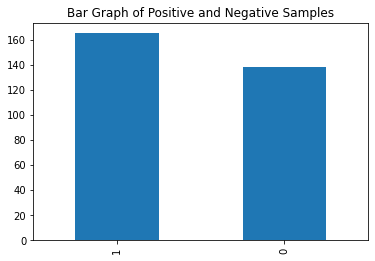

In [33]:
#Next, we will convert the categorical features to numerical values
#To determine which features are categorical, we will use the following method:
df.info()
#From this, we determine that there are no categorical features.

#To check whether the dataset is balanced or not, we will use the barplot to visualize the number of positive and negative samples.
#We are simply plotting the numbers of target values as 1 and number of target values as 0
df['target'].value_counts().plot(kind = 'bar')
plt.title('Bar Graph of Positive and Negative Samples')
plt.show()
#Based on this bar plot, we can see that the dataset is not perfectly balanced, but is pretty close (there are more samples with values of 1 than 0)

### 2.2 Split the data into two subsets and normalize the features of samples

* Split the dataset into the train_val set and testing set. 
* Normalize features

In [34]:
#Splitting the samples:
target_fea = df.drop('target', axis=1).values
target_prediction = df['target'].values


#Here, we use 14% of samples as the testing set and use the remaining samples to train the logistic regression model.
#Thus, there are 43 of the samples in the testing set and 260 of the samples to train the logistic regression model. This is important for later so that we can evenly split into 10 folds.
X_train_val, X_test, y_train_val, y_test = train_test_split(target_fea, target_prediction, 
                                                            test_size=0.14, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

#Normalizing the features:
normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

print(X_test.shape)
print(X_train_val.shape)

train_val: 260, test: 43
(43, 13)
(260, 13)


### 2.3 Train the logistic regression model and select the hyperparameter with cross-validation

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

* Use the 10-fold cross-validation to select the hyperparameter $\lambda$.
* Search $\lambda$ from $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$


In [35]:
#We need to learn the model parameter  𝐰 . 
#However, with different hyperparameters  𝜆 , we can get different model parameter  𝐰 , resulting in different prediction performance. 
#Thus, we will use the 10-fold cross-validation to select the hyperparameter  𝜆 .

#Here we set the folds equal to 10 for 10-fold cross-validation
folds = 10

#We get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

#Now, we shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

#We split the index of the train_valid set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

#As suggested above, the hyperparameters chosen are listed below
regularization_coefficient = [10**(-5), 10**(-3), 10**(-2), 10**(-1), 1, 10, 20, 50, 100]

#Variables we create to store the values of the best accuracy and best regression:
best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    #10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        #We are getting the index of the validation set and storing it in a variable valid_index
        valid_index = index_of_folds_temp[fold,:].reshape(-1) 
        #We are getting the index of the training set and storing it in a variable train_index
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1)
        
        #Our training set:
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        #Our validation set:
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        #We write this to build the model with different hyperparameters:
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #Train the model with the training set:
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    #We now want to store the best hyperparameter:
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
print("Best Accuracy: {:.4f} ".format(best_acc))
print("Best Reg: {:}".format(best_reg))


[[ 92  68 103  28   7 178 212   9 215 209 136 150  72 101  51 131 128  12
    1  41 108  53  99 256 148 232]
 [ 30 154 221  90 237  57 259  22 250 223 242  79 193  11  64 138 204 217
  145 251 245  43 230  85 146 219]
 [149  15 165 227 151 191  45 184 225 213   4 244  24 210  48  96  87  84
  114 173 207 124  29  78   3 211]
 [180 134  91 247 226   6  55 201 168  17 240 152  67 216 181  20 229 183
   65  47  62 111 141 161 147  89]
 [162 185  36 194 133 220 190  80  75 228  31  52 142  38 104 110  98 105
   25  81  21 238 188 241 143 208]
 [ 94 170 186 199  27 195 202 174 233 254  63 222 253 157 163  35  73 120
  192  76 252 155   8 175  54 179]
 [ 50 100 249 172  74 127 160 198 122 129 137 130  18  16 236  56  49  33
   95 176 159 187 126 132  26  58]
 [109 258  37 224 214  10 158 123 139 255  71 106  42  93  23  77 166 112
  196 189  59  19 234 203  83 169]
 [177 218 235 107 144  97  14 121 140 102 200  70 164  44  32 135  61  40
  257 197 239 231 125  46  69 205]
 [ 34  66   5  60  

### 2.4 Evaluate the learned model

* Report the prediction accuracy, recall, precision, and F1 score.

* Use the bar plot to visulaize the elements of the learned model parameter vector $\mathbf{w}$. Some elements  have larger absolute values, while the others do not. Try to explain this phenomenon. 

accuracy: 0.791, recall: 0.905, precision: 0.731, f1: 0.809,
Our learned model parameter vector 'w':  [0.07260054 0.20696578 0.25200775 0.07372149 0.0360397  0.02899053
 0.03336877 0.17880825 0.21720207 0.20099102 0.13853072 0.26740514
 0.1796196 ]


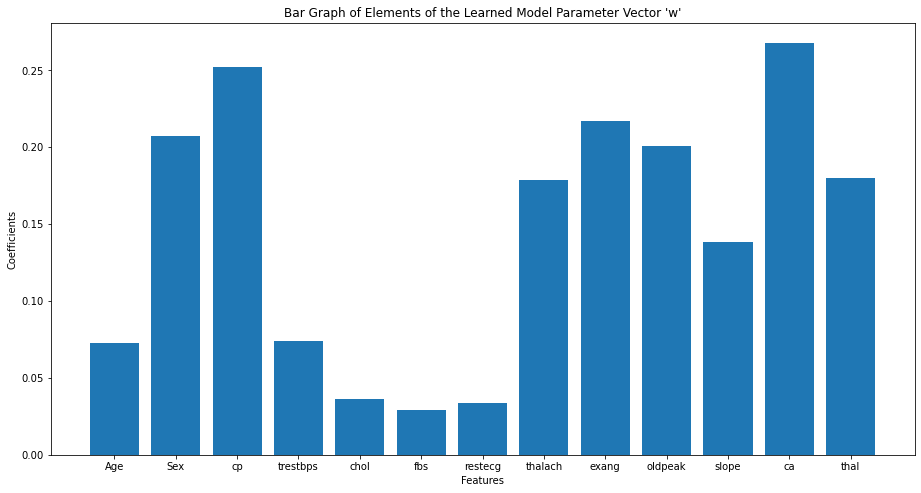

In [36]:
#Now that we have the best hyperparameter, we retrain the model:
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

#Visualizing the elements of the learned model parameter vector w with a bar plot:
print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

print("Our learned model parameter vector 'w': ", abs(clf.coef_[0]))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
labels = ['Age','Sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
coefficients = abs(clf.coef_[0])
ax.bar(labels, coefficients)
plt.title("Bar Graph of Elements of the Learned Model Parameter Vector 'w'")
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

#From this plot, we can see that some features have much greater coefficients in the learned model parameter than others.
#Specifically, Sex, cp (chest pain type), ca (the number of major vessels) have the higher coefficient values.
#This means that these features were able to fit the logistic regression model with the hyperparameter best of all of the features. 
#It tells us that the features 'Sex', 'cp', and 'ca' in our model are more statistically significant than the other features. The closer the coefficient values are to 0, the less correlation exists (that is why we took the absolute value)

#It should be noted that, although we took the absolute value of the coefficients, a positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. 
#A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.